# 바이브 코딩
*   아이디어가 작동을 하는지 테스트
*   3축 가속도 데이터를 3D 텐서 그리고 3D 이미지를 통해 학습을 하면 결과가 나올까?
*   3축 가속도 데이터를 텐서로 바꾸어 이동 궤적을 학습하여 모델을 만드는 내용을 구상
*   의사가 FOG의 큰 특징은 몸은 앞으로 음직이려 할때 발이 바닥에 붙은것 처럼 음직이지 않는 상태 -> 센서에서 그 흔들림 or 이동이 관측되지 않을까
*   각각의 가속도 값보다 가속도로 인해 생기는 흐름(궤적)이 중요할 것이라 생각
*   이를 모델링 하기 전 가능성이 있는지 확인 및 학습 방향 설정을 위해 진행

##### 요청한 내용
*   3축 가속도 데이터를 128단위로 텐서를 작성
*   단위 앞 64, 뒤64를 추가로 넣고 이전, 시작, 끝, 이후 데이터를 담은 차원 추가
*   그 후 텐서 시각화 요청
*   None:0, Start:1, Trun:2, Werking:3 라벨링을 작성
*   CNN모델로 1D, 3D 학습 모델 작성
*   그 후 결과를 시각화
*   오버피팅을 확인하고 싶어 Early Stopping이 없는 모델과도 비교

##### 결과
*   텐서 생성 성공적 하지만 형성된 shape가 원하던 모양인지 확인
*   간단한 cnn모델에서 작동을 확인
*   학습시 지속적으로 F1이 증가하는 것을 확인
*   하지만 라벨링 데이터가 아닌 원본, 신뢰구간 외의 데이터 또는 비지도 학습을 하기 위해서는 더 높은 F1을 가져야함
*   몇몇 변수 추가 후 머신러닝 모델과 비교하여 얼마나 차이가 났는지 확인비교하면 좋을것 같음

## 텐서

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D

# 경로 지정 (환경에 맞게 수정)
input_dir = Path(r"D:\Parkinson's_Freezing_of_Gait_Prediction\tlvmc-parkinsons-freezing-gait-prediction\train\tdcsfog")
output_dir = Path(r"D:\Parkinson's_Freezing_of_Gait_Prediction\tlvmc-parkinsons-freezing-gait-prediction\out_tensors")
output_dir.mkdir(parents=True, exist_ok=True)

L_HIST, L_MAIN = 64, 128
L_TOTAL = L_HIST + L_MAIN + L_HIST  # 256


In [2]:
def pick_col(df, candidates):
    cand_lower = [c.lower() for c in candidates]
    for c in df.columns:
        if c.lower() in cand_lower:
            return c
    return None

def make_rel_path(seg, anchor_idx=64, centerize=True, use_cumsum=True, unit_scale=True, eps=1e-8):
    x = seg.astype(float).copy()
    if centerize:
        x -= x.mean(axis=0, keepdims=True)
    if use_cumsum:
        x = np.cumsum(x, axis=0)
    anchor = x[anchor_idx:anchor_idx+1, :]
    x = x - anchor
    if unit_scale:
        r = np.linalg.norm(x, axis=1).max()
        if not np.isfinite(r) or r < eps:
            r = 1.0
        x = x / r
    return x

def build_windows_from_series(acc, stride_main=128):
    T = acc.shape[0]
    windows, meta = [], []
    for s in range(0, T - L_MAIN + 1, stride_main):
        if s - L_HIST < 0 or s + L_MAIN > T:
            continue
        hist_start = acc[s-L_HIST:s]
        main = acc[s:s+L_MAIN]
        hist_end = acc[s+L_MAIN-L_HIST:s+L_MAIN]
        seg = np.vstack([hist_start, main, hist_end])
        rel = make_rel_path(seg, anchor_idx=L_HIST)
        # flags
        start_flag = np.zeros((L_TOTAL,1)); end_flag = np.zeros((L_TOTAL,1))
        prev_start_flag = np.zeros((L_TOTAL,1)); prev_end_flag = np.zeros((L_TOTAL,1))
        start_flag[L_HIST,0] = 1; end_flag[L_HIST+L_MAIN-1,0] = 1
        prev_start_flag[:L_HIST,0] = 1; prev_end_flag[L_HIST+L_MAIN:,0] = 1
        packed = np.concatenate([rel, start_flag, end_flag, prev_start_flag, prev_end_flag], axis=1)
        windows.append(packed)
        meta.append((s, s+L_MAIN))
    if not windows:
        return np.zeros((0, L_TOTAL, 7)), []
    return np.stack(windows, axis=0), meta

def plot_window(sample):
    ML, AP, V = sample[:,0], sample[:,1], sample[:,2]
    start_idx, end_idx = 64, 191

    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(ML[:start_idx], AP[:start_idx], V[:start_idx], label="prev_start")
    ax.plot(ML[start_idx:end_idx+1], AP[start_idx:end_idx+1], V[start_idx:end_idx+1], label="main")
    ax.plot(ML[end_idx+1:], AP[end_idx+1:], V[end_idx+1:], label="prev_end")
    ax.scatter([ML[start_idx]], [AP[start_idx]], [V[start_idx]], c='green', s=60, label='start')
    ax.scatter([ML[end_idx]], [AP[end_idx]], [V[end_idx]], c='red', s=60, label='end')
    ax.set_xlabel("ML"); ax.set_ylabel("AP"); ax.set_zlabel("V")
    ax.legend(); plt.show()


In [3]:
csv_files = sorted(list(input_dir.glob("*.csv")))
print(f"총 {len(csv_files)}개 CSV 파일 발견")

for csv_path in csv_files:
    df = pd.read_csv(csv_path)
    col_ml = pick_col(df, ["AccML","acc_ml","accml","ml"])
    col_ap = pick_col(df, ["AccAP","acc_ap","accap","ap"])
    col_v  = pick_col(df, ["AccV","acc_v","accv","v","z"])
    if not (col_ml and col_ap and col_v):
        continue
    acc = df[[col_ml, col_ap, col_v]].to_numpy(dtype=float)
    tensor, meta = build_windows_from_series(acc, stride_main=128)
    npy_path = output_dir / f"{csv_path.stem}_tensor.npy"
    np.save(npy_path, tensor)
    print(f"{csv_path.name}: {tensor.shape} → {npy_path.name}")


총 833개 CSV 파일 발견
003f117e14.csv: (35, 256, 7) → 003f117e14_tensor.npy
009ee11563.csv: (76, 256, 7) → 009ee11563_tensor.npy
011322847a.csv: (39, 256, 7) → 011322847a_tensor.npy
01d0fe7266.csv: (54, 256, 7) → 01d0fe7266_tensor.npy
024418ba39.csv: (40, 256, 7) → 024418ba39_tensor.npy
024ba3ebd5.csv: (24, 256, 7) → 024ba3ebd5_tensor.npy
02e8454f57.csv: (28, 256, 7) → 02e8454f57_tensor.npy
02edc527c0.csv: (43, 256, 7) → 02edc527c0_tensor.npy
0330ea6680.csv: (42, 256, 7) → 0330ea6680_tensor.npy
0383be6b43.csv: (70, 256, 7) → 0383be6b43_tensor.npy
03bb0c0c46.csv: (37, 256, 7) → 03bb0c0c46_tensor.npy
03c9d8dbfa.csv: (105, 256, 7) → 03c9d8dbfa_tensor.npy
03e7159bcc.csv: (54, 256, 7) → 03e7159bcc_tensor.npy
0494003044.csv: (39, 256, 7) → 0494003044_tensor.npy
04b449020a.csv: (58, 256, 7) → 04b449020a_tensor.npy
04c2e97800.csv: (29, 256, 7) → 04c2e97800_tensor.npy
04e10e0797.csv: (112, 256, 7) → 04e10e0797_tensor.npy
0506d9a39f.csv: (39, 256, 7) → 0506d9a39f_tensor.npy
0526a6a0fd.csv: (32, 256, 7

tensor shape: (35, 256, 7)


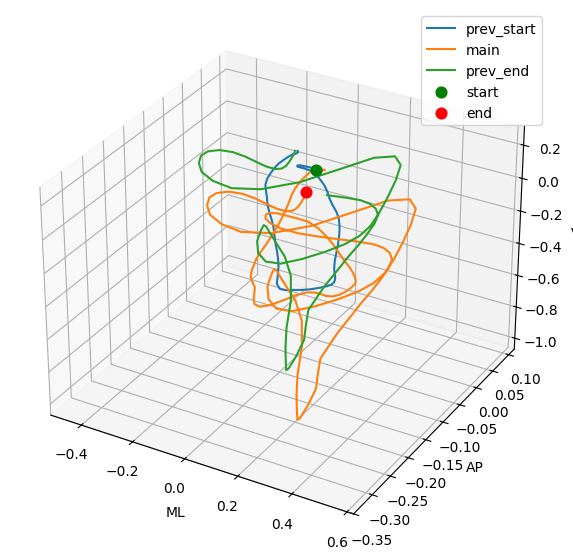

In [8]:
# 변환된 텐서 중 하나 선택
sample_file = sorted(output_dir.glob("*_tensor.npy"))[0]
tensor = np.load(sample_file)
print("tensor shape:", tensor.shape)

# 첫 번째 윈도우를 시각화
plot_window(tensor[11])


In [9]:
for i in range(min(5, tensor.shape[0])):
    sample = tensor[i]
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    ML, AP, V = sample[:,0], sample[:,1], sample[:,2]
    ax.plot(ML, AP, V)
    ax.scatter(ML[64], AP[64], V[64], c='green', s=60, label='start')
    ax.scatter(ML[191], AP[191], V[191], c='red', s=60, label='end')
    ax.set_xlabel("ML"); ax.set_ylabel("AP"); ax.set_zlabel("V")
    ax.legend()
    save_path = output_dir / f"{sample_file.stem}_win{i:03d}.png"
    plt.savefig(save_path, dpi=180)
    plt.close()
    print("저장됨:", save_path)


저장됨: D:\Parkinson's_Freezing_of_Gait_Prediction\tlvmc-parkinsons-freezing-gait-prediction\out_tensors\003f117e14_tensor_win000.png
저장됨: D:\Parkinson's_Freezing_of_Gait_Prediction\tlvmc-parkinsons-freezing-gait-prediction\out_tensors\003f117e14_tensor_win001.png
저장됨: D:\Parkinson's_Freezing_of_Gait_Prediction\tlvmc-parkinsons-freezing-gait-prediction\out_tensors\003f117e14_tensor_win002.png
저장됨: D:\Parkinson's_Freezing_of_Gait_Prediction\tlvmc-parkinsons-freezing-gait-prediction\out_tensors\003f117e14_tensor_win003.png
저장됨: D:\Parkinson's_Freezing_of_Gait_Prediction\tlvmc-parkinsons-freezing-gait-prediction\out_tensors\003f117e14_tensor_win004.png


In [10]:
import numpy as np
import pandas as pd
from pathlib import Path

# ⚙️ 경로 설정
tensor_dir = Path(r"D:\Parkinson's_Freezing_of_Gait_Prediction\tlvmc-parkinsons-freezing-gait-prediction\out_tensors")

# 라벨 정의 예시
# 실제로는 events.csv에서 윈도우의 시작시간(start_main) 기준으로
# 어떤 이벤트(Start, Walking, Turn)에 속하는지 매핑할 예정
label_map = {'Start': 0, 'Walking': 1, 'Turn': 2}

# ⚠️ 지금은 placeholder 라벨 생성 (무작위 예시)
# → 나중에 events.csv에서 자동 매핑할 코드로 교체
for tensor_path in tensor_dir.glob("*_tensor.npy"):
    X = np.load(tensor_path)
    N = X.shape[0]

    # --------------------------------------------
    # (1) 라벨 벡터 생성 (예시)
    # --------------------------------------------
    # 각 윈도우별로 랜덤 라벨을 지정 (임시)
    y = np.random.choice([0, 1, 2], size=N)
    # 실제 데이터에서는 events.csv 기반으로 교체 예정

    # --------------------------------------------
    # (2) 저장
    # --------------------------------------------
    label_path = tensor_path.with_name(tensor_path.stem.replace("_tensor", "_labels") + ".npy")
    np.save(label_path, y)
    print(f"✅ {tensor_path.name} -> {label_path.name} (shape={y.shape})")


✅ 003f117e14_tensor.npy -> 003f117e14_labels.npy (shape=(35,))
✅ 009ee11563_tensor.npy -> 009ee11563_labels.npy (shape=(76,))
✅ 011322847a_tensor.npy -> 011322847a_labels.npy (shape=(39,))
✅ 01d0fe7266_tensor.npy -> 01d0fe7266_labels.npy (shape=(54,))
✅ 024418ba39_tensor.npy -> 024418ba39_labels.npy (shape=(40,))
✅ 024ba3ebd5_tensor.npy -> 024ba3ebd5_labels.npy (shape=(24,))
✅ 02e8454f57_tensor.npy -> 02e8454f57_labels.npy (shape=(28,))
✅ 02edc527c0_tensor.npy -> 02edc527c0_labels.npy (shape=(43,))
✅ 0330ea6680_tensor.npy -> 0330ea6680_labels.npy (shape=(42,))
✅ 0383be6b43_tensor.npy -> 0383be6b43_labels.npy (shape=(70,))
✅ 03bb0c0c46_tensor.npy -> 03bb0c0c46_labels.npy (shape=(37,))
✅ 03c9d8dbfa_tensor.npy -> 03c9d8dbfa_labels.npy (shape=(105,))
✅ 03e7159bcc_tensor.npy -> 03e7159bcc_labels.npy (shape=(54,))
✅ 0494003044_tensor.npy -> 0494003044_labels.npy (shape=(39,))
✅ 04b449020a_tensor.npy -> 04b449020a_labels.npy (shape=(58,))
✅ 04c2e97800_tensor.npy -> 04c2e97800_labels.npy (shap

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN1DModel(nn.Module):
    def __init__(self, in_ch=7, num_classes=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),    # 256 → 128
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),    # 128 → 64
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # → [B,128,1]
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: [B, 7, 256]
        h = self.conv(x).squeeze(-1)  # [B,128]
        return self.fc(h)

# 예시
model = CNN1DModel(in_ch=7, num_classes=3)
print(model)


CNN1DModel(
  (conv): Sequential(
    (0): Conv1d(7, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool1d(output_size=1)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


## 3D 텐서

In [23]:
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import zipfile, os

# 경로 (원하는 로컬 경로로 바꾸세요)
INPUT_DIR  = Path(r"./train/tdcsfog")
OUTPUT_DIR = Path(r"./out_tensors")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

L_HIST, L_MAIN = 64, 128
L_TOTAL = L_HIST + L_MAIN + L_HIST  # 256

def pick_col(df, candidates):
    cands = [c.lower() for c in candidates]
    for c in df.columns:
        if c.lower() in cands: return c
    return None

def make_rel_path(seg, anchor_idx=L_HIST, centerize=True, use_cumsum=True, unit_scale=True, eps=1e-8):
    x = seg.astype(float).copy()
    if centerize: x -= x.mean(axis=0, keepdims=True)
    if use_cumsum: x = np.cumsum(x, axis=0)
    x = x - x[anchor_idx:anchor_idx+1, :]
    if unit_scale:
        r = np.linalg.norm(x, axis=1).max()
        if not np.isfinite(r) or r < eps: r = 1.0
        x = x / r
    return x

def build_windows(acc, stride_main=128):
    T = acc.shape[0]
    wins, metas = [], []
    for s in range(0, T - L_MAIN + 1, stride_main):
        if s - L_HIST < 0 or s + L_MAIN > T: continue
        hist_start = acc[s-L_HIST:s]
        main       = acc[s:s+L_MAIN]
        hist_end   = acc[s+L_MAIN-L_HIST:s+L_MAIN]
        seg = np.vstack([hist_start, main, hist_end])   # [256,3]
        rel = make_rel_path(seg, anchor_idx=L_HIST)

        start_flag = np.zeros((L_TOTAL,1)); end_flag = np.zeros((L_TOTAL,1))
        prev_start_flag = np.zeros((L_TOTAL,1)); prev_end_flag = np.zeros((L_TOTAL,1))
        start_flag[L_HIST,0] = 1; end_flag[L_HIST+L_MAIN-1,0] = 1
        prev_start_flag[:L_HIST,0] = 1; prev_end_flag[L_HIST+L_MAIN:,0] = 1

        packed = np.concatenate([rel, start_flag, end_flag, prev_start_flag, prev_end_flag], axis=1)  # [256,7]
        wins.append(packed)
        metas.append((s, s+L_MAIN))
    if not wins: return np.zeros((0, L_TOTAL, 7)), []
    return np.stack(wins, axis=0), metas


In [25]:
X_all, y_all = [], []

for csv_path in sorted(INPUT_DIR.glob("*.csv")):
    df = pd.read_csv(csv_path)
    col_ml = pick_col(df, ["AccML","acc_ml","accml","ml"])
    col_ap = pick_col(df, ["AccAP","acc_ap","accap","ap"])
    col_v  = pick_col(df, ["AccV","acc_v","accv","v","z"])
    if not (col_ml and col_ap and col_v):
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(num_cols) < 3: 
            print("skip(no 3 numeric):", csv_path.name); 
            continue
        col_ml, col_ap, col_v = num_cols[:3]
    acc = df[[col_ml,col_ap,col_v]].to_numpy(float)

    X, meta = build_windows(acc, stride_main=128)  # (N,256,7)
    if len(X)==0:
        print("skip(no windows):", csv_path.name); 
        continue

    # 👉 라벨은 나중에 events로 교체. 지금은 placeholder 0으로 만듭니다.
    y = np.zeros((X.shape[0],), dtype=np.int64)

    np.save(OUTPUT_DIR / f"{csv_path.stem}_tensor.npy", X)
    np.save(OUTPUT_DIR / f"{csv_path.stem}_labels.npy", y)
    print(f"{csv_path.name}: {X.shape} saved")

    X_all.append(X); y_all.append(y)

# (옵션) 전체 합본 저장
if X_all:
    X_cat = np.concatenate(X_all, axis=0)
    y_cat = np.concatenate(y_all, axis=0)
    np.save(OUTPUT_DIR / "all_tensor.npy", X_cat)
    np.save(OUTPUT_DIR / "all_labels.npy", y_cat)
    print("ALL:", X_cat.shape, y_cat.shape)


003f117e14.csv: (35, 256, 7) saved
009ee11563.csv: (76, 256, 7) saved
011322847a.csv: (39, 256, 7) saved
01d0fe7266.csv: (54, 256, 7) saved
024418ba39.csv: (40, 256, 7) saved
024ba3ebd5.csv: (24, 256, 7) saved
02e8454f57.csv: (28, 256, 7) saved
02edc527c0.csv: (43, 256, 7) saved
0330ea6680.csv: (42, 256, 7) saved
0383be6b43.csv: (70, 256, 7) saved
03bb0c0c46.csv: (37, 256, 7) saved
03c9d8dbfa.csv: (105, 256, 7) saved
03e7159bcc.csv: (54, 256, 7) saved
0494003044.csv: (39, 256, 7) saved
04b449020a.csv: (58, 256, 7) saved
04c2e97800.csv: (29, 256, 7) saved
04e10e0797.csv: (112, 256, 7) saved
0506d9a39f.csv: (39, 256, 7) saved
0526a6a0fd.csv: (32, 256, 7) saved
052a913d06.csv: (76, 256, 7) saved
053e7a7261.csv: (47, 256, 7) saved
0561a4912c.csv: (55, 256, 7) saved
05e892544d.csv: (52, 256, 7) saved
06228cf84a.csv: (45, 256, 7) saved
06422a906e.csv: (76, 256, 7) saved
066f785ce0.csv: (50, 256, 7) saved
0727c3a6a8.csv: (38, 256, 7) saved
07bd2e7fbc.csv: (49, 256, 7) saved
08cb8d3129.csv: (5

In [ ]:
zip_path = OUTPUT_DIR.with_suffix(".zip")
with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUTPUT_DIR.glob("*.npy"):
        zf.write(p, arcname=p.name)
print("ZIP:", zip_path)


# 4라벨링

In [30]:
from pathlib import Path
import numpy as np
import pandas as pd
import zipfile, os

# ==== 경로를 본인 환경에 맞게 수정 ====
INPUT_DIR  = Path(r"./train/tdcsfog")     # CSV들이 있는 폴더
OUTPUT_DIR = Path(r"./out_tensors")       # 결과 저장 폴더
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 윈도우 레이아웃: 64(prev_start) + 128(main) + 64(prev_end) = 256
L_HIST, L_MAIN = 64, 128
L_TOTAL = L_HIST + L_MAIN + L_HIST

# 라벨 매핑: 0=None, 1=Start, 2=Turn, 3=Walking
LABEL_MAP = {"None":0, "Start":1, "Turn":2, "Walking":3}

def pick_col(df, candidates):
    cands = [c.lower() for c in candidates]
    for c in df.columns:
        if c.lower() in cands:
            return c
    return None

def make_rel_path(seg, anchor_idx=L_HIST, centerize=True, use_cumsum=True, unit_scale=True, eps=1e-8):
    """
    seg: [256,3] (ML,AP,V) 원본 세그먼트
    - 메인 시작점(anchor_idx=64)을 원점으로 평행이동
    - 창 내에서 최대 반경으로 나눠 단위 스케일
    """
    x = seg.astype(float).copy()
    if centerize:
        x -= x.mean(axis=0, keepdims=True)
    if use_cumsum:
        x = np.cumsum(x, axis=0)           # 경로화
    x -= x[anchor_idx:anchor_idx+1, :]     # anchor를 (0,0,0)
    if unit_scale:
        r = np.linalg.norm(x, axis=1).max()
        if not np.isfinite(r) or r < eps: r = 1.0
        x = x / r
    return x

def build_windows(acc, stride_main=128):
    """
    acc: [T,3] (ML,AP,V)
    return:
      X: [N,256,7]  (ML,AP,V + start_flag, end_flag, prev_start_flag, prev_end_flag)
      main_ranges: 각 윈도우의 (start_main, end_main_exclusive) 리스트
    """
    T = acc.shape[0]
    wins, main_ranges = [], []
    for s in range(0, T - L_MAIN + 1, stride_main):
        if s - L_HIST < 0 or s + L_MAIN > T:
            continue
        hist_start = acc[s-L_HIST:s]
        main       = acc[s:s+L_MAIN]
        hist_end   = acc[s+L_MAIN-L_HIST:s+L_MAIN]
        seg = np.vstack([hist_start, main, hist_end])   # [256,3]
        rel = make_rel_path(seg, anchor_idx=L_HIST)

        # flags (7채널 중 뒤 4개)
        start_flag = np.zeros((L_TOTAL,1)); end_flag = np.zeros((L_TOTAL,1))
        prev_start_flag = np.zeros((L_TOTAL,1)); prev_end_flag = np.zeros((L_TOTAL,1))
        start_flag[L_HIST,0] = 1
        end_flag[L_HIST+L_MAIN-1,0] = 1
        prev_start_flag[:L_HIST,0] = 1
        prev_end_flag[L_HIST+L_MAIN:,0] = 1

        packed = np.concatenate([rel, start_flag, end_flag, prev_start_flag, prev_end_flag], axis=1)  # [256,7]
        wins.append(packed)
        main_ranges.append((s, s+L_MAIN))
    if not wins:
        return np.zeros((0, L_TOTAL, 7), dtype=float), []
    return np.stack(wins, axis=0), main_ranges

def infer_labels_from_row_flags(df, main_ranges, time_index_col=None):
    """
    같은 CSV 안에 per-sample 라벨 열이 있는 경우:
      열 이름 후보: ['Start','Turn','Walking'] (대소문자 무시)
      - 윈도우의 main 구간(64~191, 원본 인덱스로 s~s+128)에 대해
        Start/Turn/Walking True 개수를 세서 argmax
      - 모두 0이면 None(0)
    """
    # 후보 컬럼 찾기
    def find_flag(name_list):
        for c in df.columns:
            if c.lower() in [n.lower() for n in name_list]:
                return c
        return None

    col_start  = find_flag(['Start','start','StartHesitation','start_hesitation'])
    col_turn   = find_flag(['Turn','turn'])
    col_walk   = find_flag(['Walking','walk','walking'])

    if not (col_start or col_turn or col_walk):
        return None  # 같은 파일에서 못 찾음

    # bool로 캐스팅
    fs = df[col_start].astype(bool).to_numpy() if col_start else np.zeros(len(df), dtype=bool)
    ft = df[col_turn].astype(bool).to_numpy()  if col_turn  else np.zeros(len(df), dtype=bool)
    fw = df[col_walk].astype(bool).to_numpy()  if col_walk  else np.zeros(len(df), dtype=bool)

    labels = []
    for s, e in main_ranges:
        cs = fs[s:e].sum()
        ct = ft[s:e].sum()
        cw = fw[s:e].sum()
        if (cs==0) and (ct==0) and (cw==0):
            labels.append(0)                 # None
        else:
            # argmax: Start(1), Turn(2), Walking(3)
            vals = np.array([cs, ct, cw], dtype=float)
            idx = vals.argmax()
            labels.append(idx+1)
    return np.array(labels, dtype=np.int64)

# (선택) 별도 events.csv에서 구간형 라벨을 읽어 매핑하는 로직이 필요하면
# 아래 스텁을 구현해 연결할 수 있습니다.
def infer_labels_from_events_master(events_df, file_stem, main_ranges, fs=None, t_col=None):
    """
    필요한 경우 구현:
      - events_df에 [file_id, start_idx(or time), end_idx(or time), label] 형태가 있을 때
      - main_ranges의 (s,e)에 겹치는 label 빈도를 세어 argmax
      - 없으면 None(0)
    현재는 스텁: None 반환
    """
    return None


In [31]:
X_all, y_all = [], []

# (선택) 별도 events 마스터 CSV가 있다면 로드
EVENTS_CSV = None  # 예: Path("./train/events.csv")
events_df = pd.read_csv(EVENTS_CSV) if EVENTS_CSV and Path(EVENTS_CSV).exists() else None

for csv_path in sorted(INPUT_DIR.glob("*.csv")):
    df = pd.read_csv(csv_path)

    # 3축 가속도 열 찾기
    col_ml = pick_col(df, ["AccML","acc_ml","accml","ml"])
    col_ap = pick_col(df, ["AccAP","acc_ap","accap","ap"])
    col_v  = pick_col(df, ["AccV","acc_v","accv","v","z"])
    if not (col_ml and col_ap and col_v):
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(num_cols) < 3:
            print(f"[SKIP] 3개 수치열 없음: {csv_path.name}")
            continue
        col_ml, col_ap, col_v = num_cols[:3]

    acc = df[[col_ml,col_ap,col_v]].to_numpy(float)  # [T,3]
    X, main_ranges = build_windows(acc, stride_main=128)  # [N,256,7], list of (s,e)
    if len(X)==0:
        print(f"[SKIP] 윈도우 없음: {csv_path.name}")
        continue

    # 라벨 추론: (1) 같은 CSV에 per-row 플래그가 있으면 거기서, (2) 아니면 events_master에서, (3) 둘다 없으면 None
    y = infer_labels_from_row_flags(df, main_ranges)
    if y is None and events_df is not None:
        y = infer_labels_from_events_master(events_df, csv_path.stem, main_ranges)
    if y is None:
        y = np.zeros((X.shape[0],), dtype=np.int64)  # 전부 None(0)

    # 저장
    np.save(OUTPUT_DIR / f"{csv_path.stem}_tensor.npy", X)
    np.save(OUTPUT_DIR / f"{csv_path.stem}_labels.npy", y)
    print(f"[OK] {csv_path.stem}: X={X.shape}, y={y.shape}  (None비율={(y==0).mean():.2%})")

    X_all.append(X); y_all.append(y)

# (옵션) 전체 합본도 저장
if X_all:
    X_cat = np.concatenate(X_all, axis=0)
    y_cat = np.concatenate(y_all, axis=0)
    np.save(OUTPUT_DIR / "all_tensor.npy", X_cat)
    np.save(OUTPUT_DIR / "all_labels.npy", y_cat)
    print(f"[ALL] X={X_cat.shape}, y={y_cat.shape}, 클래스분포={dict(zip(*np.unique(y_cat, return_counts=True)))}")


[OK] 003f117e14: X=(35, 256, 7), y=(35,)  (None비율=80.00%)
[OK] 009ee11563: X=(76, 256, 7), y=(76,)  (None비율=52.63%)
[OK] 011322847a: X=(39, 256, 7), y=(39,)  (None비율=92.31%)
[OK] 01d0fe7266: X=(54, 256, 7), y=(54,)  (None비율=96.30%)
[OK] 024418ba39: X=(40, 256, 7), y=(40,)  (None비율=100.00%)
[OK] 024ba3ebd5: X=(24, 256, 7), y=(24,)  (None비율=100.00%)
[OK] 02e8454f57: X=(28, 256, 7), y=(28,)  (None비율=100.00%)
[OK] 02edc527c0: X=(43, 256, 7), y=(43,)  (None비율=100.00%)
[OK] 0330ea6680: X=(42, 256, 7), y=(42,)  (None비율=100.00%)
[OK] 0383be6b43: X=(70, 256, 7), y=(70,)  (None비율=100.00%)
[OK] 03bb0c0c46: X=(37, 256, 7), y=(37,)  (None비율=89.19%)
[OK] 03c9d8dbfa: X=(105, 256, 7), y=(105,)  (None비율=87.62%)
[OK] 03e7159bcc: X=(54, 256, 7), y=(54,)  (None비율=100.00%)
[OK] 0494003044: X=(39, 256, 7), y=(39,)  (None비율=100.00%)
[OK] 04b449020a: X=(58, 256, 7), y=(58,)  (None비율=86.21%)
[OK] 04c2e97800: X=(29, 256, 7), y=(29,)  (None비율=100.00%)
[OK] 04e10e0797: X=(112, 256, 7), y=(112,)  (None비율=44.64%)
[